Het voorspellen van de bondprijs alleen op basis van historische waarde van de bond is waarschijnlijk nooit erg succesvol. Voor een betere voorspelling zullen we 'leading indicatoren' moeten hebben. Indicatoren die iets zeggen waar de markt naar toe gaat.

Voor dit onderzoek richt ik mij op deze indicatoren:
- Remaining Duration
- Theoretical Bond Prices
- Inflation curve
- Referentie bond (10 jaars bonds, met zelfde maturity)
- Term Spread
- Bid Offer Spread

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if IS_COLAB:
    !git clone https://github.com/Merijn68/BondTrading.git    
    %pip install -q "ray[tune]" bayesian-optimization
    %pip install loguru tensorflow-addons
    %cd BondTrading

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "..")

import math
from src.data import make_dataset
from src.models import base_model,evaluate, hyper
from src.visualization import visualize
from src.features import build_features
from pathlib import Path
import pandas as pd
from src.models import window

import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as tfl
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt


In [3]:
if IS_COLAB:
    df_bonds = make_dataset.get_bond_data(path = Path("data/raw/Bonds.csv"))
    df_bonds = make_dataset.impute_bonds(df_bonds)
    df_price = make_dataset.get_price(path = Path("data/raw/price.csv"))
    df_price = make_dataset.impute_price(df_price)
    df_bp = make_dataset.join_price(df_bonds,df_price )
    df_bp = make_dataset.build_features.add_duration(df_bp)
else:
    df_bp = make_dataset.read_pkl('bp', path = Path("data/processed/")) 
   
isin = "NL0011220108" # 10 Years NL Bond, maturity 2025 0.25% coupon
df_isin = df_bp[df_bp['reference_identifier'] == isin]

2022-01-26 11:59:09.386 | INFO     | src.data.make_dataset:read_pkl:418 - Load preprocessed bp data


In [4]:
# Add theoretically calculated bond price 
if IS_COLAB:
    df_yield = make_dataset.get_yield(path = Path("data/raw/yield.csv"))
    df_yield = make_dataset.impute_yield(df_yield)  
else:
    df_yield = make_dataset.read_pkl('yield', path = Path("data/processed/")) 
df_isin_ytm = make_dataset.join_ytm(df_isin, df_yield)
df_isin_ytm = build_features.add_estimated_bond_price(df_isin_ytm)

2022-01-26 11:59:09.984 | INFO     | src.data.make_dataset:read_pkl:418 - Load preprocessed yield data


<AxesSubplot:xlabel='rate_dt'>

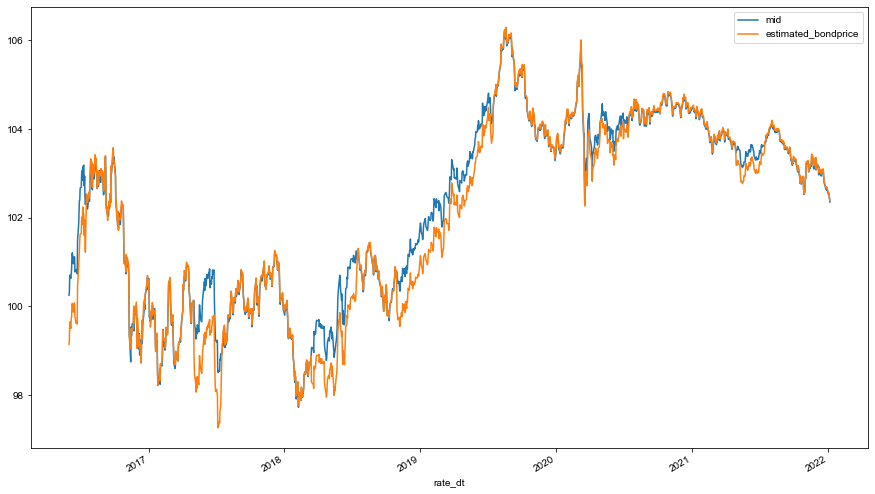

In [5]:
df_isin_ytm.plot(x = 'rate_dt',y = ['mid','estimated_bondprice'], figsize = (15,9))

<AxesSubplot:xlabel='rate_dt'>

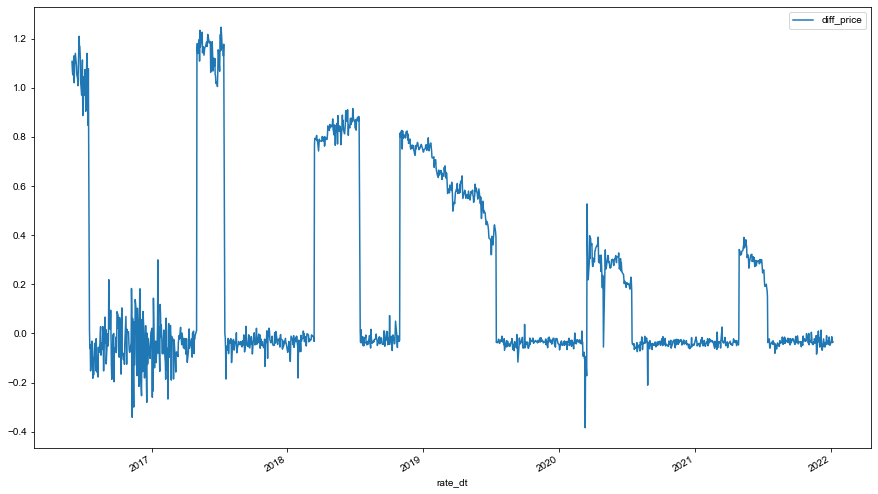

In [6]:
df_isin_ytm['diff_price'] = df_isin_ytm['mid'] - df_isin_ytm['estimated_bondprice']
df_isin_ytm.plot(x = 'rate_dt',y = 'diff_price', figsize = (15,9))

In [7]:
# Add Term Spread and Bid-Offer spread
df_bpy = make_dataset.join_yield(df_isin_ytm, df_yield)
df_bpy = build_features.add_term_spread(df_bpy)
df_bpy = build_features.add_bid_offer_spread(df_bpy)

2022-01-26 11:59:11.996 | INFO     | src.features.build_features:add_term_spread:64 - Add term spread...
2022-01-26 11:59:11.999 | INFO     | src.features.build_features:add_bid_offer_spread:75 - Add bid offer spread...


In [8]:
# Add inflation
if IS_COLAB:
    df_inflation = make_dataset.get_inflation(path = Path("data\\raw\\")
    df_inflation = make_dataset.impute_inflation(df_inflation)    
else:
    df_inflation = make_dataset.read_pkl('inflation', path = Path("data/processed/")) 
df_bpyi = make_dataset.join_infl(df_bpy, df_inflation, country = 'Germany')

2022-01-26 11:59:15.144 | INFO     | src.data.make_dataset:read_pkl:418 - Load preprocessed inflation data


In [9]:
# reference bonds
df_mature_2025 = df_bp.loc[( df_bp['mature_dt'].dt.year == 2025 )]
filter =    ( df_mature_2025['coupon'] > 0 ) & \
            ( df_mature_2025['rate_dt'] > '1-jun-2016' ) & \
            ( df_mature_2025['country'] != 'Netherlands' )  
            # ( df_mature_2025['reference_identifier']).isin(['AT0000A1FAP5','BE0000334434','DE0001102374','DE0001102382','FR0012517027','FR0012938116','IT0005090318'])

df_mature_2025 = df_mature_2025.loc[filter]
df_r = df_mature_2025.pivot(index = 'rate_dt', columns = 'reference_identifier', values = 'mid').dropna(axis = 'columns')


<AxesSubplot:xlabel='rate_dt'>

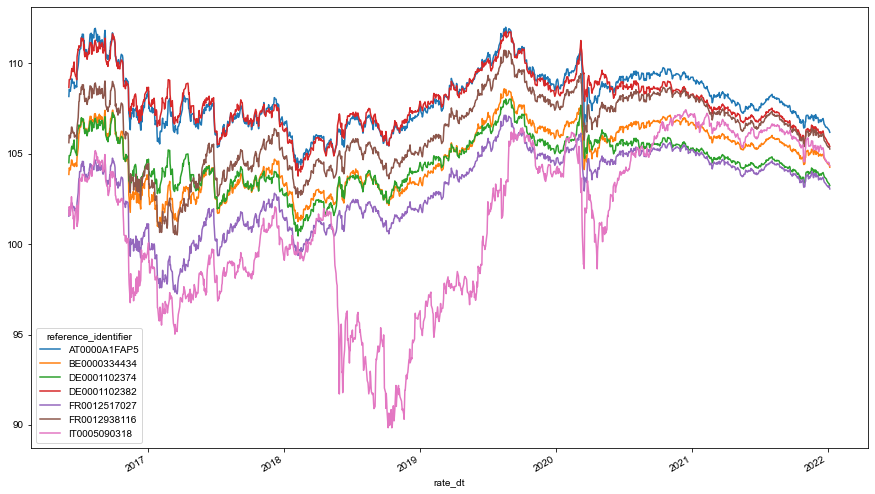

In [10]:

df_r.plot(figsize = (15,9))

In [11]:
df_bpyir = df_bpyi.merge(df_r, on = 'rate_dt', how = 'inner' )
df_bpyir

,reference_identifier,rate_dt,ccy,mid,lastday,country,bond_ext_name,issue_dt,first_coupon_date,mature_dt,...,7 YEARS,8 YEARS,9 YEARS,AT0000A1FAP5,BE0000334434,DE0001102374,DE0001102382,FR0012517027,FR0012938116,IT0005090318
0,NL0011220108,2016-06-02,EUR,100.319,2016-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,1.16000,1.27500,1.39250,108.171,103.858,104.508,108.670,101.550,105.616,101.619
1,NL0011220108,2016-06-03,EUR,100.702,2016-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,1.15000,1.26500,1.38250,108.562,104.220,104.903,109.103,101.916,106.036,102.073
2,NL0011220108,2016-06-06,EUR,100.632,2016-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,1.15500,1.26750,1.39250,108.459,104.109,104.914,109.124,101.776,105.883,101.598
3,NL0011220108,2016-06-07,EUR,100.751,2016-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,1.15500,1.27000,1.39250,108.661,104.349,105.067,109.298,101.984,106.132,102.078
4,NL0011220108,2016-06-08,EUR,100.841,2016-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,1.16750,1.27250,1.39500,108.756,104.364,105.101,109.335,102.001,106.133,102.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,NL0011220108,2021-12-17,EUR,103.034,2021-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,2.21625,2.20625,2.20375,106.888,104.943,103.912,106.212,103.648,106.057,105.311
1409,NL0011220108,2021-12-20,EUR,103.070,2021-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,2.21875,2.21000,2.20875,106.951,104.978,103.965,106.265,103.703,106.112,105.329
1410,NL0011220108,2021-12-21,EUR,102.951,2021-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,2.28125,2.27625,2.27500,106.835,104.885,103.884,106.149,103.602,105.977,105.216
1411,NL0011220108,2021-12-22,EUR,102.820,2021-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,2.35250,2.34750,2.34375,106.691,104.791,103.789,106.024,103.523,105.838,105.047


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_bpyi = df_bpyi[['rate_dt','mid','estimated_bondprice','term_spread','bid_offer_spread_10','10 YEARS']]
df_bpyi.columns = ['rate_dt','mid','estimated_bondprice','term_spread','bid_offer_spread_10y','inflation_10y']
df_bpyi = df_bpyi.set_index('rate_dt')
df_bpyi = df_bpyi.sort_index()


In [13]:
series = df_bpyi['mid']
split = math.floor(len(series) * .70)

# Train test split
train = df_bpyi[:split].copy()
test = df_bpyi[split:].copy()

scaler.fit(train)
train[train.columns] = scaler.fit_transform(train[train.columns])
test[test.columns] = scaler.transform(test[test.columns])


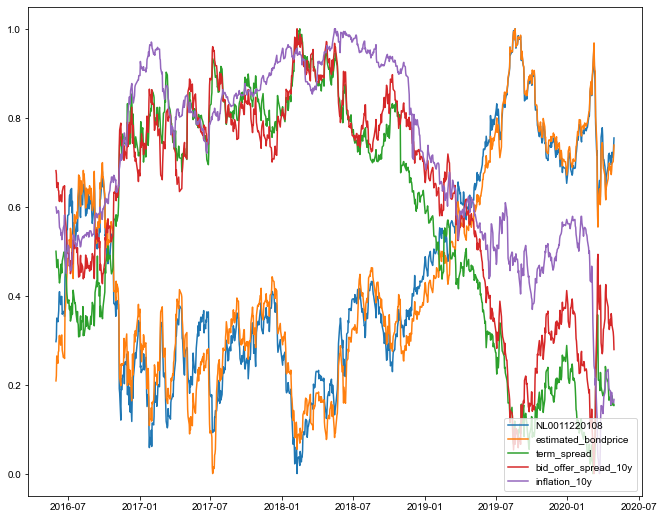

In [14]:
plt.rcParams["figure.figsize"] = [11, 9]
line1, = plt.plot(train.iloc[:,0], label=isin)
line2, = plt.plot(train.iloc[:,1], label="estimated_bondprice")
line3, = plt.plot(train.iloc[:,2], label="term_spread")
line4, = plt.plot(train.iloc[:,3], label="bid_offer_spread_10y")
line4, = plt.plot(train.iloc[:,4], label="inflation_10y")
leg = plt.legend(loc='lower right')


De correlatie tussen deze items is verbasingwekkend. Ik zie nog niet hoe dit mogelijk is. De de spread tussen bid en ask prijzen en de spread tussen 2 years en 10 years bonds volgen bijna naadloos een zelfde trend als de ontwikkeling van de marktwaarde van de bond. Wanneer we deze spreads even omdraaien wordt dit nog duidelijker.

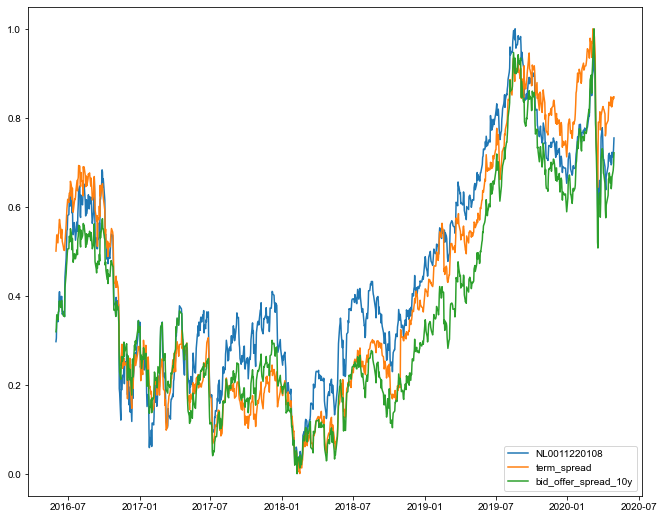

In [15]:
plt.rcParams["figure.figsize"] = [11, 9]
line1, = plt.plot(train.iloc[:,0], label=isin)
line3, = plt.plot(train.iloc[:,2] * -1 + 1, label="term_spread")
line4, = plt.plot(train.iloc[:,3] * -1 + 1, label="bid_offer_spread_10y")
leg = plt.legend(loc='lower right')

In [16]:
# Create a windowed dataset from the data
window_size = 32 
batch_size = 32
shuffle_buffer = 2
horizon = 10
train_set = window.windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)
valid_set = window.windowed_dataset(test, window_size, batch_size, shuffle_buffer, horizon=horizon)

2022-01-26 11:33:40.292 | INFO     | src.models.window:windowed_dataset:14 - Split windowed dataset window_size = 32, batch_size =  32, shuffle_buffer =  2, horizon =  10
2022-01-26 11:33:44.051 | INFO     | src.models.window:windowed_dataset:14 - Split windowed dataset window_size = 32, batch_size =  32, shuffle_buffer =  2, horizon =  10


In [17]:
y, yhat = base_model.naivepredict(train.iloc[:, 0].values)
norm = evaluate.mae(y, yhat)
evaluate.mae(y, yhat), evaluate.mse(y, yhat), evaluate.mase(y, yhat)

(0.01771326338598396, 0.0005914568464814363, 0.9994436519273704)

In [18]:
# Mean Absolute Error - for horizon
norm = base_model.calc_mae_for_horizon(train_set, horizon)
print(norm)
smae = evaluate.ScaledMAE(scale=norm)

0.043184147593896764


In [19]:
x, y = next(iter(train_set))
x.shape, y.shape

(TensorShape([32, 32, 5]), TensorShape([32, 10]))

In [20]:
result = {}
models = {}

In [21]:
model = Sequential([             
        tfl.SimpleRNN(5),         
        tfl.Dense(10)
    ])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
lr = 1e-2
model.compile(loss="mse", optimizer=Adam(learning_rate=lr), metrics=["mae", smae])
model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[early_stop], verbose=1)

Epoch 1/200
30/30 [==============================] - 8s 173ms/step - loss: 0.1157 - mae: 0.2591 - smae: 6.0005 - val_loss: 0.0731 - val_mae: 0.2177 - val_smae: 5.0405
Epoch 2/200
30/30 [==============================] - 3s 91ms/step - loss: 0.0904 - mae: 0.2547 - smae: 5.8985 - val_loss: 0.0278 - val_mae: 0.1291 - val_smae: 2.9905
Epoch 3/200
30/30 [==============================] - 3s 86ms/step - loss: 0.0406 - mae: 0.1653 - smae: 3.8277 - val_loss: 0.0139 - val_mae: 0.0999 - val_smae: 2.3145
Epoch 4/200
30/30 [==============================] - 3s 94ms/step - loss: 0.0266 - mae: 0.1310 - smae: 3.0329 - val_loss: 0.0066 - val_mae: 0.0700 - val_smae: 1.6210
Epoch 5/200
30/30 [==============================] - 3s 110ms/step - loss: 0.0283 - mae: 0.1402 - smae: 3.2470 - val_loss: 0.0060 - val_mae: 0.0647 - val_smae: 1.4992
Epoch 6/200
30/30 [==============================] - 4s 149ms/step - loss: 0.0364 - mae: 0.1611 - smae: 3.7296 - val_loss: 0.0066 - val_mae: 0.0666 - val_smae: 1.5428
E

In [24]:
# Remove log files before tuning models
if IS_COLAB:
  !rm -rf logs/
else:
  !del logs /Q
  !del %USERPROFILE%\AppData\Local\Temp\.tensorboard-info\*.* /Q

In [25]:
%load_ext tensorboard

In [26]:
%tensorboard --logdir logs

In [27]:
# Hypertune

from ray import tune
config = {
    "datadir" : Path("data").absolute(),
    "grace_period" : 3,
    "local_dir" : "logs",
    "epochs" : 20,
    "samples" : 25,
    "timeDistributed" : tune.choice([True, False]),
    "features": 5,
    "window" : tune.randint(5, 30),    
    "filters" : tune.randint(2, 32),
    "kernel" : tune.randint(1, 8),
    "type" : tune.choice(["GRU", "LSTM"]),
    "optimizer" : tune.choice(["Adam", "RMSprop"]),
    "hidden" : tune.randint(1, 5),
    "units" : tune.qrandint(16, 256, 16),
    "horizon" : 10,
    "shape3d" : True    
}

In [29]:
analysis = hyper.hypertune(train, test, config)

Trial name,status,loc,filters,hidden,kernel,optimizer,timeDistributed,type,units,window
wrapper_daaba_00000,PENDING,,8,3,6,Adam,True,GRU,160,24
wrapper_daaba_00001,PENDING,,22,2,2,Adam,False,LSTM,32,20
wrapper_daaba_00002,PENDING,,22,3,4,Adam,True,GRU,96,13
wrapper_daaba_00003,PENDING,,5,2,2,RMSprop,False,GRU,32,29
wrapper_daaba_00004,PENDING,,5,1,3,RMSprop,False,GRU,192,23
wrapper_daaba_00005,PENDING,,30,1,1,RMSprop,True,GRU,80,15
wrapper_daaba_00006,PENDING,,22,3,6,RMSprop,True,LSTM,112,19
wrapper_daaba_00007,PENDING,,27,1,4,RMSprop,False,LSTM,192,11
wrapper_daaba_00008,PENDING,,9,2,4,RMSprop,False,GRU,128,10
wrapper_daaba_00009,PENDING,,23,1,5,Adam,False,LSTM,176,24


2022-01-26 11:44:20,629	ERROR tune.py:622 -- Trials did not complete: [wrapper_daaba_00000, wrapper_daaba_00001, wrapper_daaba_00002, wrapper_daaba_00003, wrapper_daaba_00004, wrapper_daaba_00005, wrapper_daaba_00006, wrapper_daaba_00007, wrapper_daaba_00008, wrapper_daaba_00009, wrapper_daaba_00010, wrapper_daaba_00011, wrapper_daaba_00012, wrapper_daaba_00013, wrapper_daaba_00014, wrapper_daaba_00015]
2022-01-26 11:44:20,630	INFO tune.py:626 -- Total run time: 27.57 seconds (27.31 seconds for the tuning loop).
2022-01-26 11:44:20,630	WARNING tune.py:630 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


In [ ]:
fig = visualize.plot_example(
    valid_set, 
    window_size = window_size, 
    horizon = horizon, 
    examples = 3, 
    model = model,
    figurepath = Path("reports/figures"), 
    name = 'example base model')